In [1]:
import numpy as np
import pandas as pd
import pickle
#from build_database import flux_obj
from scipy import interpolate
import matplotlib.pyplot as plt
import os
import itertools
import random
import os
import time
import datetime as dt

from spacepy import coordinates as coord
from spacepy.time import Ticktock

from raytracer_utils import readdump, read_rayfile, read_rayfiles
from mpl_toolkits.mplot3d import Axes3D
#%matplotlib inline
%matplotlib nbagg
# Autoload changes made in external editor:
%load_ext autoreload
%autoreload 2
# --------------- Latex Plot Beautification --------------------------
fig_width = 12 
fig_height = 4
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 14,
          'font.size': 14,
          'legend.fontsize': 14,
          'xtick.labelsize': 14,
          'ytick.labelsize': 14,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------

In [469]:
# Here's how to run the c code:
# (this code interpolates rays + damping onto a uniform time axis,
# then calculates geometric spreading at the center of each "tube", defined
# by four corner rays. The result is a measure of wave power (w/m^2) at
# each timestep. )


ray_inp_dir = '/shared/users/asousa/WIPP/lightning_power_study/rays/globe_ngo'
outfile_name= '/shared/users/asousa/WIPP/lightning_power_study/test_dump.dat'
f1 = 200
f2 = 230
time_max = 12.0
num_times = 100
max_ground_distance = 800
freq_step_size=10

cmd = '../bin/main --ray_dir=%s --out_file=%s'%(ray_inp_dir, outfile_name) + \
       ' --f1=%d --f2=%d --t_max=%g --num_times=%d'%(f1, f2, time_max, num_times) + \
       ' --max_dist=%d --freq_step_size=%d'%(max_ground_distance, freq_step_size)
print cmd


os.system(cmd)

../bin/main --ray_dir=/shared/users/asousa/WIPP/lightning_power_study/rays/globe_ngo --out_file=/shared/users/asousa/WIPP/lightning_power_study/test_dump.dat --f1=200 --f2=230 --t_max=12 --num_times=100 --max_dist=800 --freq_step_size=10


0

(3, 8, 100, 4)
(3, 8, 100, 4)


<IPython.core.display.Javascript object>


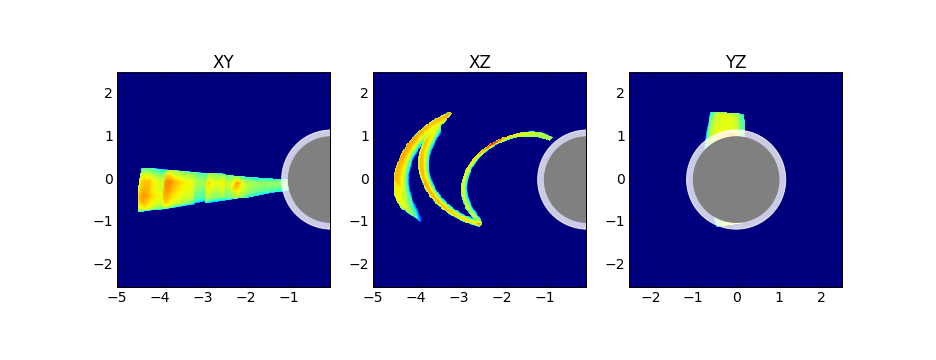

<IPython.core.display.Javascript object>


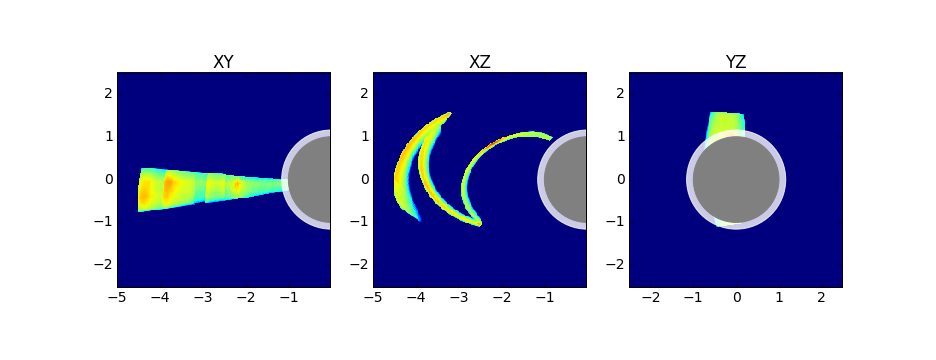

<IPython.core.display.Javascript object>


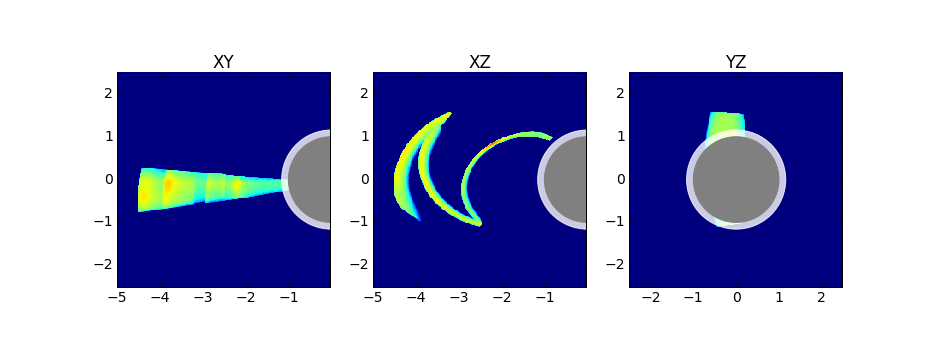

In [477]:
# Load file (sparse list of coordinates + powers, vs time)
# fname = '/shared/users/asousa/WIPP/lightning_power_study/test_dump_prev.dat'
fname = outfile_name
data_raw = np.loadtxt(fname)

R_E = 6371e3
H_IONO = 1000e3
nf = int(data_raw[0]) # num frequencies
nv = int(data_raw[1]) # num vectors
nt = int(data_raw[2]) # num timesteps

dgrid = data_raw[3:]

dgrid = np.reshape(dgrid, [nf,nv,nt,4],order='c')
# dgrid = np.reshape(dgrid, [nf*nv*nt,4],order='c')

print np.shape(dgrid)



import scipy.interpolate
XMIN =-5
XMAX =0
YMIN =-2.5
YMAX =2.5
ZMIN =-2.5
ZMAX =2.5
GRID_STEP_SIZE =0.02

clims = [-12,-7]

xx = np.arange(XMIN, XMAX, GRID_STEP_SIZE)
yy = np.arange(YMIN, YMAX, GRID_STEP_SIZE)
zz = np.arange(ZMIN, ZMAX, GRID_STEP_SIZE)

nx = len(xx) 
ny = len(yy)
nz = len(zz)

print np.shape(dgrid)
data = np.zeros([nx, ny, nz])
hits = np.zeros([nx, ny, nz])


for f_ind in range(nf):
    for t in range(1,nt):
        points = dgrid[f_ind,:,t-1:t+2,0:3]
        vals = dgrid[f_ind,:,t-1:t+2,3]
        vals_flat = vals.ravel()
        points_flat = np.vstack([points[:,:,0].ravel(), points[:,:,1].ravel(), points[:,:,2].ravel()]).T

        minx = min(points_flat[:,0])
        maxx = max(points_flat[:,0])
        miny = min(points_flat[:,1])
        maxy = max(points_flat[:,1])
        minz = min(points_flat[:,2])
        maxz = max(points_flat[:,2])

        ix = np.where((xx >= minx) & (xx <= maxx))[0]
        iy = np.where((yy >= miny) & (yy <= maxy))[0]
        iz = np.where((zz >= minz) & (zz <= maxz))[0]

        px, py, pz = np.meshgrid(ix, iy, iz)

        newpoints = np.vstack([xx[px.ravel()], yy[py.ravel()], zz[pz.ravel()]]).T
        newinds   = np.vstack([px, py, pz]).T
        # If we don't specify a fill value, 'linear' mode returns NaN for anything outside
        # the convex hull of the current point cloud (which is ideal -- we don't want any
        # values calculated outside the (non-convex) hull.)
        tmp_data = interpolate.griddata(points_flat, vals_flat, newpoints, method='linear', rescale=False)

        tmp_data = tmp_data.reshape([len(iy), len(ix), len(iz)])
        isnans = np.isnan(tmp_data)
        tmp_data[np.isnan(tmp_data)] = 0

    #     print np.sum(isnans), np.sum(~isnans)
        data[px,py,pz] += tmp_data
        hits[px,py,pz] += ~isnans


    data[hits!=0] /= (pow(hits[hits!=0],1))

    xz_sum = np.log10((np.sum(data, axis=1).T))
    xy_sum = np.log10((np.sum(data, axis=2).T))
    yz_sum = np.log10((np.sum(data, axis=0).T))

    xy_sum[np.isinf(xy_sum)] = -100
    xz_sum[np.isinf(xz_sum)] = -100
    yz_sum[np.isinf(yz_sum)] = -100

    fig, ax = plt.subplots(1,3)
    # Plot the earth
    for i in [0, 1, 2]:
        earth = plt.Circle((0,0),1,color='0.5',alpha=1, zorder=100)
        iono  = plt.Circle((0,0),(R_E + H_IONO)/R_E, color='w',alpha=0.8, zorder=99)
        ax[i].add_patch(earth)   
        ax[i].add_patch(iono)
    
    ax[0].pcolorfast(xx, yy, xy_sum, vmin=clims[0], vmax=clims[1])
    ax[1].pcolorfast(xx, zz, xz_sum, vmin=clims[0], vmax=clims[1])
    ax[2].pcolorfast(yy, zz, yz_sum, vmin=clims[0], vmax=clims[1])

    ax[0].set_aspect('equal')
    ax[1].set_aspect('equal')
    ax[2].set_aspect('equal')

    ax[0].set_title('XY')
    ax[1].set_title('XZ')
    ax[2].set_title('YZ')
    
    ax[0].set_xlim([xx[0],xx[-1]])
    ax[0].set_ylim([yy[0],yy[-1]])
    ax[1].set_xlim([xx[0],xx[-1]])
    ax[1].set_ylim([zz[0],zz[-1]])
    ax[2].set_xlim([yy[0],yy[-1]])
    ax[2].set_ylim([zz[0],zz[-1]])

<IPython.core.display.Javascript object>


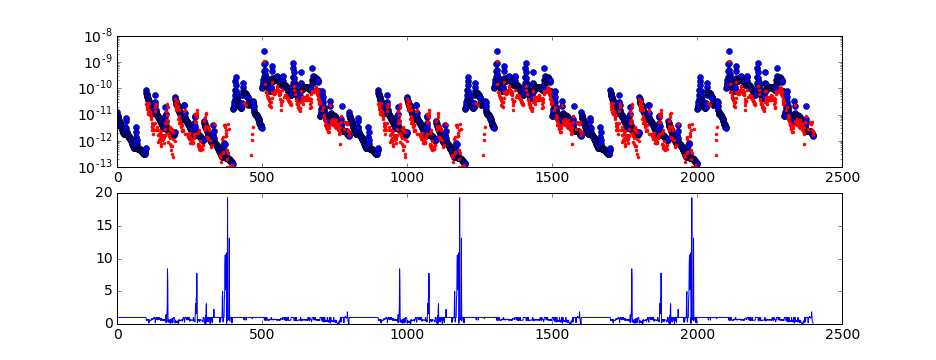

In [485]:
# Check how well it matches with the known data:

# Find closest values in interpolated grid to the current rays:

xraw = dgrid[:,:,:,0].ravel()
yraw = dgrid[:,:,:,1].ravel()
zraw = dgrid[:,:,:,2].ravel()
data_raw = dgrid[:,:,:,3].ravel()

# Quantize to our sampling grid
xq   = np.digitize(xraw, xx)
yq   = np.digitize(yraw, yy)
zq   = np.digitize(zraw, zz)

dq = data[xq, yq, zq]

fig, ax = plt.subplots(2,1)

ax[0].semilogy(data_raw,'bo')
ax[0].semilogy(dq,'r.')

ax[1].plot(abs(data_raw - dq)/abs(data_raw))


(1, 21, 500, 4)


<IPython.core.display.Javascript object>


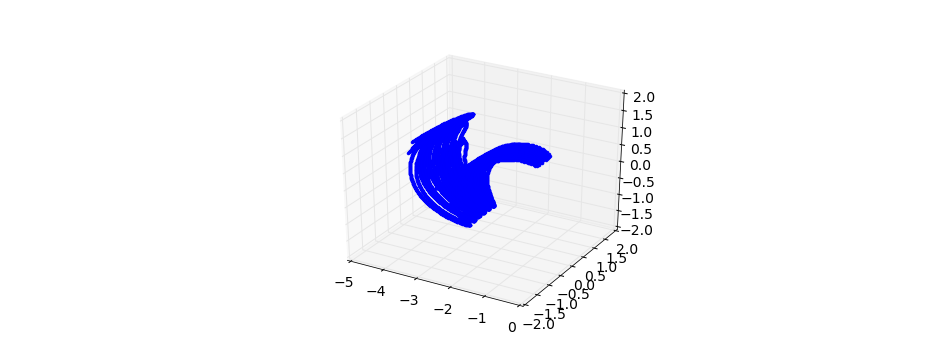

(-2, 2)

In [454]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


# Handy 3d plotter to show where the original power samples are:

# Load file (sparse list of coordinates + powers, vs time)
fname = '/shared/users/asousa/WIPP/lightning_power_study/test_dump_prev.dat'

data_raw = np.loadtxt(fname)

nf = int(data_raw[0]) # num frequencies
nv = int(data_raw[1]) # num vectors
nt = int(data_raw[2]) # num timesteps

dgrid = data_raw[3:]

dgrid = np.reshape(dgrid, [nf,nv,nt,4],order='c')
# dgrid = np.reshape(dgrid, [nf*nv*nt,4],order='c')

print np.shape(dgrid)


f_ind = 0;




fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for v in range(nv):
    ax.plot(dgrid[0,v,:,0],dgrid[0,v,:,1],dgrid[0,v,:,2],'b.')

# ax.plot(dgrid[:,0],dgrid[:,1],dgrid[:,2],'b.')


ax.set_aspect('equal')
ax.set_xlim([-5,0])
ax.set_ylim([-2,2])
ax.set_zlim([-2,2])
